In [522]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score


from imblearn.over_sampling import SMOTE

- Women with ADHD penalized twice as much 
- Try graph neural net and convolutional neural net

In [523]:
def custom_f1_score(y_true_sex, y_true_adhd, y_pred_sex, y_pred_adhd):
    """
    Custom F1 where misclassifying female ADHD as male ADHD is doubly penalized.
    """

    # First, compute "normal" F1
    f1_sex = f1_score(y_true_sex, y_pred_sex)
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd)

    # Then, manually penalize the bad case
    penalty = 0

    for yt_sex, yt_adhd, yp_sex, yp_adhd in zip(
        y_true_sex, y_true_adhd, y_pred_sex, y_pred_adhd
    ):
        if yt_sex == 1 and yt_adhd == 1:  # True female with ADHD
            if yp_sex == 0 and yp_adhd == 1:  # Predicted male with ADHD
                penalty += 2  # Double penalty for this misclassification

    # Combine scores
    final_score = (f1_sex + f1_adhd) / 2  # Normal average F1
    final_score = final_score - (penalty / len(y_true_sex))  # Subtract penalty

    return final_score


def custom_penalty_loss(y_true_sex, y_true_adhd, y_pred_sex, y_pred_adhd):
    """
    Adds penalty when a Female with ADHD is misclassified as a Male with ADHD.
    """

    penalty = 0.0
    for yt_sex, yt_adhd, yp_sex, yp_adhd in zip(
        y_true_sex, y_true_adhd, y_pred_sex, y_pred_adhd
    ):
        if yt_sex == 1 and yt_adhd == 1:
            if yp_sex == 0 and yp_adhd == 1:
                penalty += 2.0  # double penalty

    # Normalize penalty
    penalty = penalty / len(y_true_sex)
    return penalty

### Load in the training data

In [524]:
# Use read_excel and use participant_id as the index
train_cat = pd.read_excel("../data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_func = pd.read_csv("../data/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
train_quant = pd.read_excel("../data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_soln = pd.read_excel("../data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

In [525]:
display(train_cat.head(), train_func.head(), train_quant.head(), train_soln.head())

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,...,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
1,WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,...,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176
2,4PAQp1M6EyAo,-0.116833,0.458408,0.260703,0.639031,0.769337,0.442528,0.637110,0.192010,0.520379,...,0.342487,-0.021141,-0.037836,0.075069,0.412712,0.292708,0.391005,0.461544,0.508912,0.624232
3,obEacy4Of68I,0.199688,0.752714,0.658283,0.575096,0.692867,0.645789,0.522750,0.412188,0.530843,...,0.103562,-0.178313,0.210983,-0.018666,0.436313,0.592982,0.216205,0.341272,0.440313,0.558193
4,s7WzzDcmDOhF,0.227321,0.613268,0.621447,0.562673,0.736709,0.589813,0.266676,0.359668,0.300771,...,-0.164956,0.007064,-0.120904,-0.488095,0.493575,-0.215361,0.210685,0.055850,0.119065,0.108273


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


In [526]:
data_dict = pd.read_excel("../data/Data Dictionary.xlsx")
data_dict

,DataType,Instrument,Field,Description,Type,Labels
0,QUANTITATIVE METADATA,NaN,NaN,NaN,NaN,NaN
1,NaN,Identifier,participant_id,Participant ID,str,NaN
2,Quantitative,Edinburgh Handedness Questionnaire,EHQ_EHQ_Total,Laterality Index (Score),float,-100 = 10th left\n−28 ≤ LI < 48 = middle\n100 ...
3,Quantitative,Ishihara Color Vision Test,ColorVision_CV_Score,Color vision test score,int,NaN
4,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_CP,Corporal Punishment Score,int,NaN
5,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_ID,Inconsistent Discipline Score,int,NaN
6,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_INV,Involvement Score,int,NaN
7,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_OPD,Other Discipline Practices Score (Not factored...,int,NaN
8,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PM,Poor Monitoring/Supervision Score,int,NaN
9,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PP,Positive Parenting Score,int,NaN


## train_cat: One-hot encoding on the categorical values
1. Turn the numbers into their labels using the values provided in the data dictionary.
2. Use pandas to perform one-hot encoding so that the models can interpret the binary values instead of arbitrary numbers.

In [527]:
Basic_Demos_Study_Site = {
    1: "Staten Island",
    2: "MRV",
    3: "Midtown",
    4: "Harlem",
    5: "SI RUMC",
}

PreInt_Demos_Fam_Child_Ethnicity = {
    0: "Not Hispanic or Latino",
    1: "Hispanic or Latino",
    2: "Decline to specify",
    3: "Unknown"
}

PreInt_Demos_Fam_Child_Race = {
  0: "White/Caucasian",
  1: "Black/African American",
  2: "Hispanic",
  3: "Asian",
  4: "Indian",
  5: "Native American Indian",
  6: "American Indian/Alaskan Native",
  7: "Native Hawaiian/Other Pacific Islander",
  8: "Two or more races",
  9: "Other race",
  10: "Unknown",
  11: "Chose not to specify"}

MRI_Track_Scan_Location = {
    1: "Staten Island",
    2: "RUBIC", 
    3: "CBIC",
    4: "CUNY"
}

Barratt_Barratt_P1_Edu = {
    3: "Less than 7th grade",
    6: "Junior high/Middle school (9th grade)",
    9: "Partial high school (10th or 11th grade)",
    12: "High school graduate",
    15: "Partial college (at least one year)",
    18: "College education",
    21: "Graduate degree"
}

Barratt_Barratt_P1_Occ = {
    0: "Homemaker, stay at home parent.",
    5: "Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.",
    10: "Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.",
    15: "Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.",
    20: "Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.",
    25: "Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.",
    30: "Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",
    35: "Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.",
    40: "Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.",
    45: "Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant."
}

Barratt_Barratt_P2_Edu = {
    3: "Less than 7th grade",
    6: "Junior high/Middle school (9th grade)",
    9: "Partial high school (10th or 11th grade)",
    12: "High school graduate",
    15: "Partial college (at least one year)",
    18: "College education",
    21: "Graduate degree"
}

Barratt_Barratt_P2_Occ = {
    0: "Homemaker, stay at home parent.",
    5: "Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.",
    10: "Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.",
    15: "Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.",
    20: "Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.",
    25: "Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.",
    30: "Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",
    35: "Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.",
    40: "Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.",
    45: "Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.",
}



In [528]:
# Apply label replacements using the dictionaries
train_cat["Basic_Demos_Study_Site"] = train_cat["Basic_Demos_Study_Site"].replace(
    Basic_Demos_Study_Site
)
train_cat["PreInt_Demos_Fam_Child_Ethnicity"] = train_cat[
    "PreInt_Demos_Fam_Child_Ethnicity"
].replace(PreInt_Demos_Fam_Child_Ethnicity)
train_cat["PreInt_Demos_Fam_Child_Race"] = train_cat[
    "PreInt_Demos_Fam_Child_Race"
].replace(PreInt_Demos_Fam_Child_Race)
train_cat["MRI_Track_Scan_Location"] = train_cat["MRI_Track_Scan_Location"].replace(
    MRI_Track_Scan_Location
)
train_cat["Barratt_Barratt_P1_Edu"] = train_cat["Barratt_Barratt_P1_Edu"].replace(
    Barratt_Barratt_P1_Edu
)
train_cat["Barratt_Barratt_P1_Occ"] = train_cat["Barratt_Barratt_P1_Occ"].replace(
    Barratt_Barratt_P1_Occ
)
train_cat["Barratt_Barratt_P2_Edu"] = train_cat["Barratt_Barratt_P2_Edu"].replace(
    Barratt_Barratt_P2_Edu
)
train_cat["Barratt_Barratt_P2_Occ"] = train_cat["Barratt_Barratt_P2_Occ"].replace(
    Barratt_Barratt_P2_Occ
)

In [529]:
# One-hot encode all columns except 'participant_id' and 'Basic_Demos_Enroll_Year'
train_cat_encoded = pd.get_dummies(
    train_cat,
    columns=[
        "Basic_Demos_Study_Site",
        "PreInt_Demos_Fam_Child_Ethnicity",
        "PreInt_Demos_Fam_Child_Race",
        "MRI_Track_Scan_Location",
        "Barratt_Barratt_P1_Edu",
        "Barratt_Barratt_P1_Occ",
        "Barratt_Barratt_P2_Edu",
        "Barratt_Barratt_P2_Occ",
    ],
    dummy_na=True,  # Optional: adds a column for NaNs if present
    drop_first=False,  # Set to True if you want to drop the first category to avoid multicollinearity
)

# Check the result
train_cat_encoded.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site_Harlem,Basic_Demos_Study_Site_MRV,Basic_Demos_Study_Site_Midtown,Basic_Demos_Study_Site_Staten Island,Basic_Demos_Study_Site_nan,PreInt_Demos_Fam_Child_Ethnicity_Decline to specify,PreInt_Demos_Fam_Child_Ethnicity_Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Not Hispanic or Latino,...,"Barratt_Barratt_P2_Occ_Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.","Barratt_Barratt_P2_Occ_Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.","Barratt_Barratt_P2_Occ_Homemaker, stay at home parent.","Barratt_Barratt_P2_Occ_Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.","Barratt_Barratt_P2_Occ_Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.","Barratt_Barratt_P2_Occ_Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.","Barratt_Barratt_P2_Occ_Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.","Barratt_Barratt_P2_Occ_Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.","Barratt_Barratt_P2_Occ_Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",Barratt_Barratt_P2_Occ_nan
0,00aIpNTbG5uh,2019,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,00fV0OyyoLfw,2017,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,04X1eiS79T4B,2017,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,05ocQutkURd6,2018,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,06YUNBA9ZRLq,2018,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


## train_func: reduce the dimensionality of the functional MRI connectome matrix

Original shape: (1213, 19900)
Transformed shape: (1213, 464)


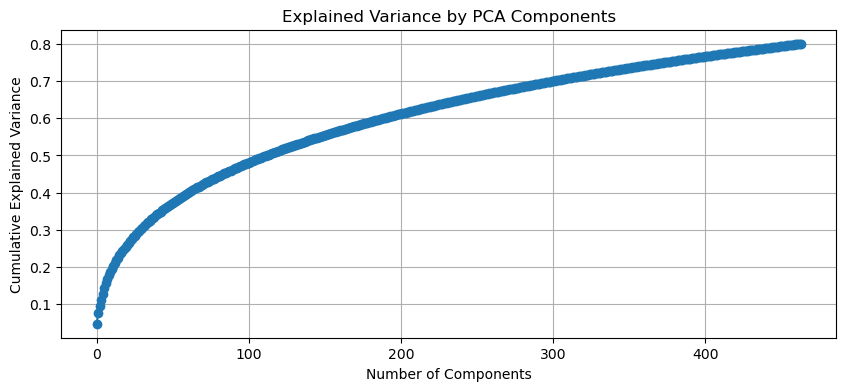

In [530]:
# Separate the features (connectome matrix) from the participant IDs
X = train_func.drop(columns=["participant_id"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Want to capture 75% of the variance
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X_scaled)

# Shape of the transformed data
print("Original shape:", X_scaled.shape)
print("Transformed shape:", X_pca.shape)

# Explained variance
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

In [531]:
train_func_pca = pd.DataFrame(
    X_pca,
    index=train_func["participant_id"],
    columns=[f"fmri_pca_{i+1}" for i in range(X_pca.shape[1])],
)
train_func_pca.head()

,fmri_pca_1,fmri_pca_2,fmri_pca_3,fmri_pca_4,fmri_pca_5,fmri_pca_6,fmri_pca_7,fmri_pca_8,fmri_pca_9,fmri_pca_10,...,fmri_pca_455,fmri_pca_456,fmri_pca_457,fmri_pca_458,fmri_pca_459,fmri_pca_460,fmri_pca_461,fmri_pca_462,fmri_pca_463,fmri_pca_464
participant_id,,,,,,,,,,,,,,,,,,,,,
70z8Q2xdTXM3,35.753597,0.090543,-20.350098,-19.088315,-30.805000,2.306746,0.012355,-16.080110,-6.713655,7.132238,...,2.444320,2.246306,-0.601253,-0.318204,-2.567000,-4.188951,-0.423559,2.751428,1.282703,-4.683491
WHWymJu6zNZi,28.459455,-18.887916,10.232790,-1.115161,-7.235638,-14.893705,5.991655,-3.274425,-18.623446,-12.154646,...,0.823866,-3.250062,-5.154873,4.001859,1.863844,-1.724962,3.029928,1.894485,0.494266,-5.851479
4PAQp1M6EyAo,0.798687,4.718468,10.989505,17.687384,10.643912,31.792714,-9.804087,16.585635,-15.010728,-8.778202,...,-5.095345,-3.494166,1.078176,-0.983331,-4.876152,-3.644965,-1.572020,-0.539341,-1.401308,0.602506
obEacy4Of68I,-45.767171,-11.453186,4.095472,-12.695696,-20.976370,22.331782,4.630708,-4.709863,0.145218,10.252135,...,-8.181315,3.897831,0.253571,0.590245,-0.110259,0.937680,-0.855990,5.276611,-3.118190,2.629994
s7WzzDcmDOhF,3.746646,-8.847485,10.058838,2.305610,-3.341812,14.484016,28.106098,5.519340,-6.920033,4.655665,...,3.944539,-2.646924,1.673610,3.358918,1.923088,-0.500143,1.875633,0.253948,-0.448169,4.047551


In [532]:
# Deal with NaN values
train_quant = train_quant.fillna(
    train_quant.drop("participant_id", axis=1).mean()
)
train_quant.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,11.245678
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


### Make one input matrix X by merging on participant_id
Currently, the dataframes are:
- train_cat_encoded (one-hot encoded so all binary)
- train_func_pca (reduced to 374 PCs)
- train_quant (dealt with NaN values)
- they all have 1213 rows, so the merging shouldn't lose any data
- they all have the participant_id column, which will uniquely merge each row

In [533]:
cat_func_merge = pd.merge(train_cat_encoded, train_func_pca, how='outer', on="participant_id")
X_with_id = pd.merge(cat_func_merge, train_quant, how="outer", on="participant_id")
X = X_with_id.drop("participant_id", axis=1)
# Turn boolean columns into integers (0/1)
X = X.astype({col: int for col in X.select_dtypes("bool").columns})
X.head()

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site_Harlem,Basic_Demos_Study_Site_MRV,Basic_Demos_Study_Site_Midtown,Basic_Demos_Study_Site_Staten Island,Basic_Demos_Study_Site_nan,PreInt_Demos_Fam_Child_Ethnicity_Decline to specify,PreInt_Demos_Fam_Child_Ethnicity_Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Not Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Unknown,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,2019,1,0,0,0,0,0,1,0,0,...,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,2017,0,0,0,1,0,0,0,1,0,...,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,11.245678
2,2017,0,0,0,1,0,0,1,0,0,...,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,2018,0,0,0,1,0,0,0,0,1,...,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,2018,0,0,0,1,0,0,0,1,0,...,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [534]:
y_sex = train_soln["Sex_F"]  
y_adhd = train_soln["ADHD_Outcome"] 

### Want to try to handle the weight issues by bootstrapping from the female values


In [535]:
# X_and_y = pd.merge(X_with_id, train_soln, how='outer', on="participant_id")
# female_pt = X_and_y[X_and_y["Sex_F"] == 1]
# male_pt = X_and_y[X_and_y["Sex_F"] == 0]

# # Randomly sample rows until we have equal male and female representation
# rows_to_add = female_pt.sample(n=len(male_pt) - len(female_pt), replace=True)   # how many more males there are than females
# X_new = pd.concat([X_and_y, rows_to_add])
# X_new # Now we have 797 records of each

# X = X_new.drop(columns=["Sex_F", "ADHD_Outcome", "participant_id"])

# y_sex = X_new["Sex_F"]
# y_adhd = X_new["ADHD_Outcome"]

In [536]:
train_soln.head()

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


## Neural Net

#### First, build a NN just for classifying sex

In [537]:
# Split into train and validation using y_sex
X_train, X_val, y_train_sex, y_val_sex, y_train_adhd, y_val_adhd = train_test_split(
    X, y_sex, y_adhd, test_size=0.2, random_state=42
)

In [538]:
# Scale inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [539]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_train_tensor = X_train_tensor.to("cpu")
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)

y_train_tensor_sex = torch.tensor(y_train_sex.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor_sex = torch.tensor(y_val_sex.values, dtype=torch.float32).unsqueeze(1)

y_train_tensor_adhd = torch.tensor(y_train_adhd.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor_adhd = torch.tensor(y_val_adhd.values, dtype=torch.float32).unsqueeze(1)

In [540]:
from sklearn.utils.class_weight import compute_class_weight
import torch

class_weights_sex = compute_class_weight(
    class_weight="balanced", classes=[0, 1], y=y_train_tensor_sex.numpy().flatten()
)
# Convert to tensor
class_weights_sex = torch.tensor(class_weights_sex)


class_weights_adhd = compute_class_weight(
    class_weight="balanced", classes=[0, 1], y=y_train_tensor_adhd.numpy().flatten()
)

# Convert to tensor
class_weights_adhd = torch.tensor(class_weights_adhd)

In [541]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

Epoch [0/50] - Train Loss: 0.8052 - Val Loss: 0.7775 - Train Accuracy: 0.6381 - Train F1: 0.0057 - Train Recall: 0.0029 - Val Accuracy: 0.5597 - Val F1: 0.3815 - Val Recall: 0.4583
Epoch [5/50] - Train Loss: 0.7695 - Val Loss: 0.7559 - Train Accuracy: 0.6464 - Train F1: 0.0058 - Train Recall: 0.0029 - Val Accuracy: 0.6996 - Val F1: 0.0000 - Val Recall: 0.0000
Epoch [10/50] - Train Loss: 0.7347 - Val Loss: 0.7480 - Train Accuracy: 0.6454 - Train F1: 0.0000 - Train Recall: 0.0000 - Val Accuracy: 0.6996 - Val F1: 0.0000 - Val Recall: 0.0000
Epoch [15/50] - Train Loss: 0.6927 - Val Loss: 0.7465 - Train Accuracy: 0.6515 - Train F1: 0.0343 - Train Recall: 0.0174 - Val Accuracy: 0.6790 - Val F1: 0.0000 - Val Recall: 0.0000
Epoch [20/50] - Train Loss: 0.6268 - Val Loss: 0.7505 - Train Accuracy: 0.7000 - Train F1: 0.2670 - Train Recall: 0.1541 - Val Accuracy: 0.6337 - Val F1: 0.0430 - Val Recall: 0.0278
Epoch [25/50] - Train Loss: 0.5420 - Val Loss: 0.7653 - Train Accuracy: 0.7680 - Train F1: 0

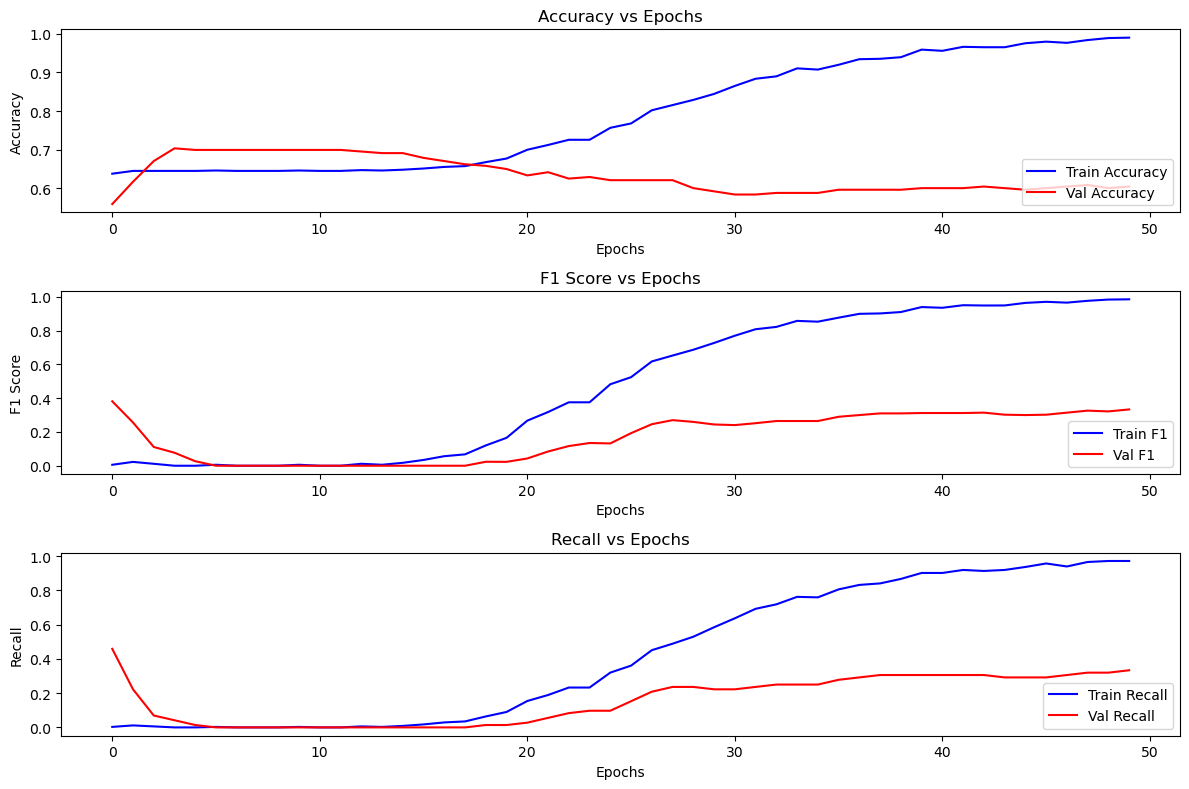

In [542]:
# Instantiate model
model_sex = SimpleNN(input_dim=X_train.shape[1])

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(
    pos_weight=class_weights_sex[1]
)  # weight for the minority class

# criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = torch.optim.Adam(model_sex.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize lists to store metrics
train_acc_list = []
train_f1_list = []
train_recall_list = []
val_acc_list = []
val_f1_list = []
val_recall_list = []

# Training loop for sex classification
n_epochs = 50
for epoch in range(n_epochs):
    model_sex.train()

    # Forward pass
    outputs = model_sex(X_train_tensor)
    loss = criterion(outputs, y_train_tensor_sex)

    # Apply threshold to get binary predictions
    preds_train = (outputs > 0.5).float()

    # Compute metrics for training
    train_acc = accuracy_score(y_train_tensor_sex.numpy(), preds_train.numpy())
    train_f1 = f1_score(y_train_tensor_sex.numpy(), preds_train.numpy())
    train_recall = recall_score(y_train_tensor_sex.numpy(), preds_train.numpy())

    # Append metrics to lists
    train_acc_list.append(train_acc)
    train_f1_list.append(train_f1)
    train_recall_list.append(train_recall)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model_sex.eval()
    with torch.no_grad():
        outputs = model_sex(X_val_tensor)
        val_loss = criterion(
            outputs, y_val_tensor_sex
        )  # <--- add this line to compute validation loss
        preds = torch.sigmoid(outputs)
        preds_val = (preds > 0.5).float()

        # Compute metrics for validation
        val_acc = accuracy_score(y_val_tensor_sex.numpy(), preds_val.numpy())
        val_f1 = f1_score(y_val_tensor_sex.numpy(), preds_val.numpy())
        val_recall = recall_score(y_val_tensor_sex.numpy(), preds_val.numpy())

        # Append validation metrics to lists
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)
        val_recall_list.append(val_recall)

    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch}/{n_epochs}] - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f} "
            f"- Train Accuracy: {train_acc:.4f} - Train F1: {train_f1:.4f} - Train Recall: {train_recall:.4f} "
            f"- Val Accuracy: {val_acc:.4f} - Val F1: {val_f1:.4f} - Val Recall: {val_recall:.4f}"
        )


# Plotting the metrics
epochs = list(range(n_epochs))
plt.figure(figsize=(12, 8))

# Plot accuracy
plt.subplot(3, 1, 1)
plt.plot(epochs, train_acc_list, label="Train Accuracy", color="b")
plt.plot(epochs, val_acc_list, label="Val Accuracy", color="r")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy vs Epochs")

# Plot F1 score
plt.subplot(3, 1, 2)
plt.plot(epochs, train_f1_list, label="Train F1", color="b")
plt.plot(epochs, val_f1_list, label="Val F1", color="r")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend(loc="lower right")
plt.title("F1 Score vs Epochs")

# Plot recall
plt.subplot(3, 1, 3)
plt.plot(epochs, train_recall_list, label="Train Recall", color="b")
plt.plot(epochs, val_recall_list, label="Val Recall", color="r")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(loc="lower right")
plt.title("Recall vs Epochs")

plt.tight_layout()
plt.show()

Epoch [0/50] - Train Loss: 0.9528 - Val Loss: 0.9215 - Train Accuracy: 0.3278 - Train F1: 0.0031 - Train Recall: 0.0015 - Val Accuracy: 0.7160 - Val F1: 0.8288 - Val Recall: 0.9382
Epoch [5/50] - Train Loss: 0.8275 - Val Loss: 0.8196 - Train Accuracy: 0.4309 - Train F1: 0.3381 - Train Recall: 0.2159 - Val Accuracy: 0.7325 - Val F1: 0.8456 - Val Recall: 1.0000
Epoch [10/50] - Train Loss: 0.7366 - Val Loss: 0.7451 - Train Accuracy: 0.6876 - Train F1: 0.7757 - Train Recall: 0.8025 - Val Accuracy: 0.7325 - Val F1: 0.8456 - Val Recall: 1.0000
Epoch [15/50] - Train Loss: 0.6696 - Val Loss: 0.7046 - Train Accuracy: 0.7278 - Train F1: 0.8288 - Train Recall: 0.9786 - Val Accuracy: 0.7325 - Val F1: 0.8456 - Val Recall: 1.0000
Epoch [20/50] - Train Loss: 0.6033 - Val Loss: 0.6995 - Train Accuracy: 0.7206 - Train F1: 0.8277 - Train Recall: 0.9969 - Val Accuracy: 0.7325 - Val F1: 0.8456 - Val Recall: 1.0000
Epoch [25/50] - Train Loss: 0.5461 - Val Loss: 0.7150 - Train Accuracy: 0.7381 - Train F1: 0

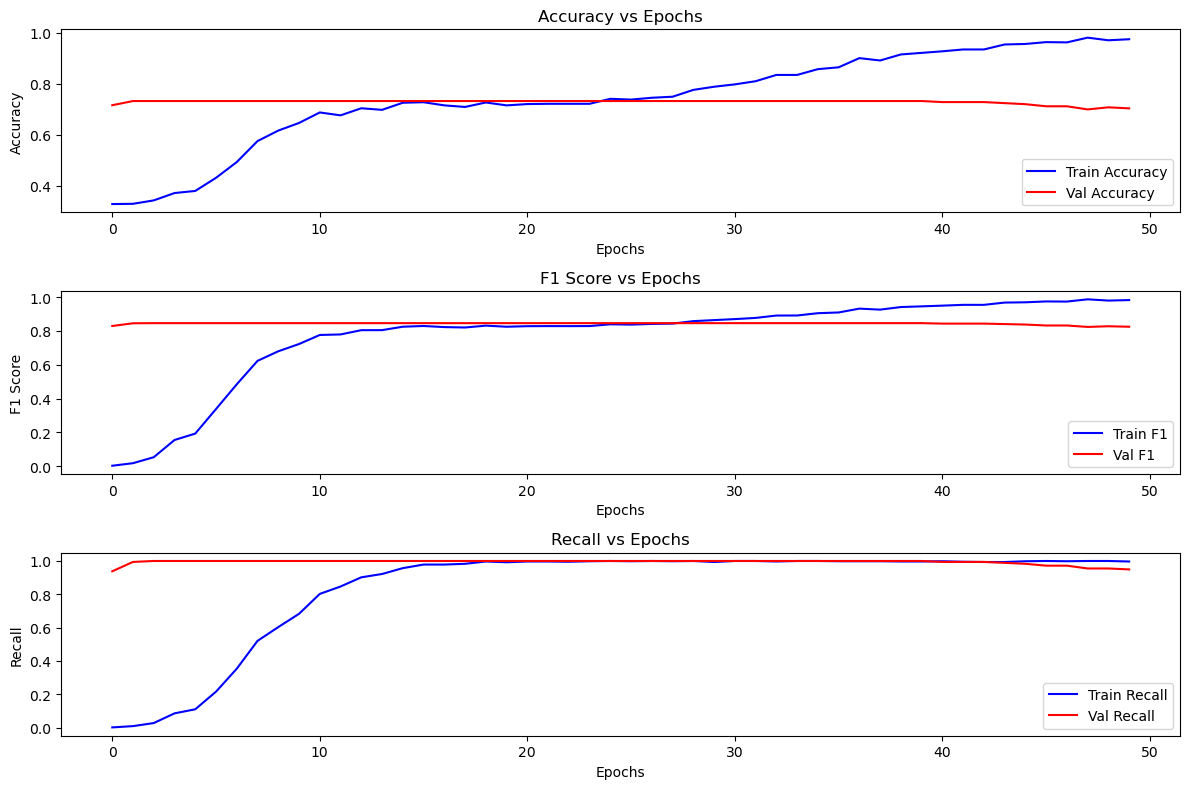

In [543]:
# Instantiate model
model_adhd = SimpleNN(input_dim=X_train.shape[1])

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(
    pos_weight=class_weights_adhd[0]
)  # weight for the minority class

# criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = torch.optim.Adam(model_adhd.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize lists to store metrics
train_acc_list = []
train_f1_list = []
train_recall_list = []
val_acc_list = []
val_f1_list = []
val_recall_list = []

# Training loop for ADHD classification
n_epochs = 50
for epoch in range(n_epochs):
    model_adhd.train()

    # Forward pass
    outputs = model_adhd(X_train_tensor)
    loss = criterion(outputs, y_train_tensor_adhd)

    # Apply threshold to get binary predictions
    preds_train = (outputs > 0.5).float()

    # Compute metrics for training
    train_acc = accuracy_score(y_train_tensor_adhd.numpy(), preds_train.numpy())
    train_f1 = f1_score(y_train_tensor_adhd.numpy(), preds_train.numpy())
    train_recall = recall_score(y_train_tensor_adhd.numpy(), preds_train.numpy())

    # Append metrics to lists
    train_acc_list.append(train_acc)
    train_f1_list.append(train_f1)
    train_recall_list.append(train_recall)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model_adhd.eval()
    with torch.no_grad():
        outputs = model_adhd(X_val_tensor)
        val_loss = criterion(
            outputs, y_val_tensor_adhd
        )  # <--- add this line to compute validation loss
        preds = torch.sigmoid(outputs)
        preds_val = (preds > 0.5).float()

        # Compute metrics for validation
        val_acc = accuracy_score(y_val_tensor_adhd.numpy(), preds_val.numpy())
        val_f1 = f1_score(y_val_tensor_adhd.numpy(), preds_val.numpy())
        val_recall = recall_score(y_val_tensor_adhd.numpy(), preds_val.numpy())

        # Append validation metrics to lists
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)
        val_recall_list.append(val_recall)

    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch}/{n_epochs}] - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f} "
            f"- Train Accuracy: {train_acc:.4f} - Train F1: {train_f1:.4f} - Train Recall: {train_recall:.4f} "
            f"- Val Accuracy: {val_acc:.4f} - Val F1: {val_f1:.4f} - Val Recall: {val_recall:.4f}"
        )


# Plotting the metrics
epochs = list(range(n_epochs))
plt.figure(figsize=(12, 8))

# Plot accuracy
plt.subplot(3, 1, 1)
plt.plot(epochs, train_acc_list, label="Train Accuracy", color="b")
plt.plot(epochs, val_acc_list, label="Val Accuracy", color="r")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy vs Epochs")

# Plot F1 score
plt.subplot(3, 1, 2)
plt.plot(epochs, train_f1_list, label="Train F1", color="b")
plt.plot(epochs, val_f1_list, label="Val F1", color="r")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend(loc="lower right")
plt.title("F1 Score vs Epochs")

# Plot recall
plt.subplot(3, 1, 3)
plt.plot(epochs, train_recall_list, label="Train Recall", color="b")
plt.plot(epochs, val_recall_list, label="Val Recall", color="r")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(loc="lower right")
plt.title("Recall vs Epochs")

plt.tight_layout()
plt.show()

Epoch [0/50] - Train Loss: 1.5120 - Val Loss: 0.2459 - Train Accuracy: 0.4845 - Train F1: 0.4457 - Train Recall: 0.5843 - Val Accuracy: 0.6049 - Val F1: 0.2258 - Val Recall: 0.1944
Epoch [5/50] - Train Loss: 1.5995 - Val Loss: 0.0524 - Train Accuracy: 0.6670 - Train F1: 0.3654 - Train Recall: 0.2703 - Val Accuracy: 0.7037 - Val F1: 0.0000 - Val Recall: 0.0000
Epoch [10/50] - Train Loss: 1.6000 - Val Loss: 0.0524 - Train Accuracy: 0.6938 - Train F1: 0.3235 - Train Recall: 0.2064 - Val Accuracy: 0.7037 - Val F1: 0.0000 - Val Recall: 0.0000
Epoch [15/50] - Train Loss: 1.4603 - Val Loss: 0.0935 - Train Accuracy: 0.7495 - Train F1: 0.4863 - Train Recall: 0.3343 - Val Accuracy: 0.6996 - Val F1: 0.0519 - Val Recall: 0.0278
Epoch [20/50] - Train Loss: 1.2315 - Val Loss: 0.1700 - Train Accuracy: 0.8237 - Train F1: 0.6941 - Train Recall: 0.5640 - Val Accuracy: 0.6749 - Val F1: 0.1684 - Val Recall: 0.1111
Epoch [25/50] - Train Loss: 1.0216 - Val Loss: 0.2115 - Train Accuracy: 0.8773 - Train F1: 0

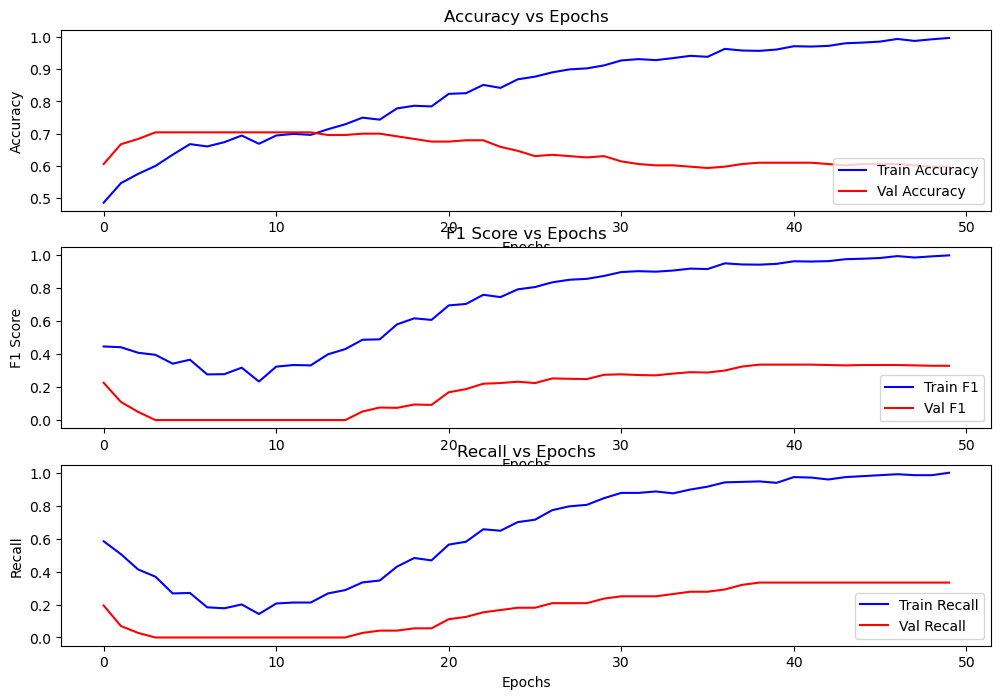

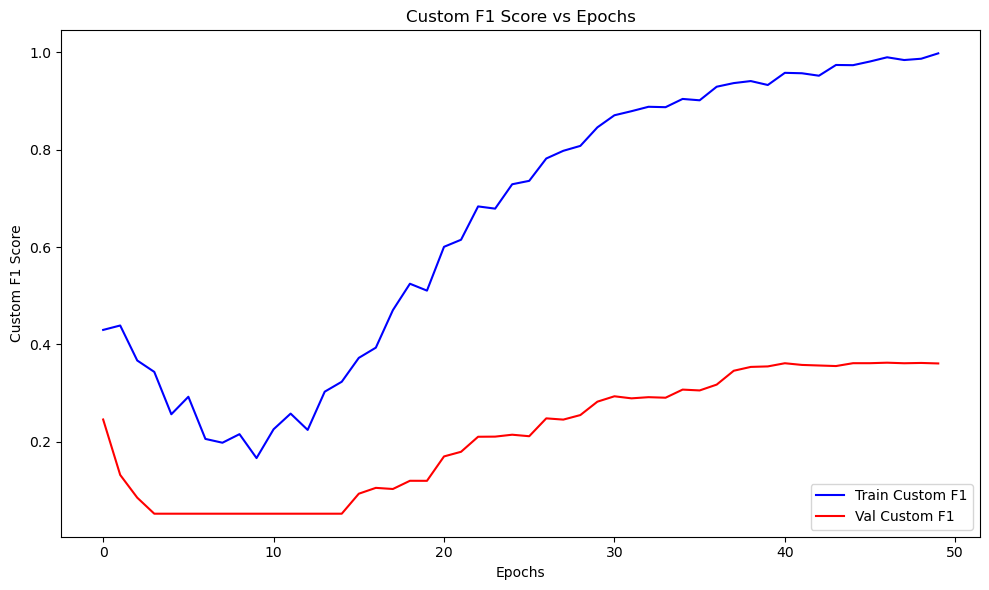

In [544]:
# Training loop for both sex and ADHD classification with custom F1 and penalty loss

# Define the model, optimizer, and loss functions
model_sex = SimpleNN(input_dim=X_train.shape[1])
model_adhd = SimpleNN(
    input_dim=X_train.shape[1]
)  # Assuming similar model for ADHD classification

criterion_sex = nn.BCEWithLogitsLoss(pos_weight=class_weights_sex[1])  # sex class weights
criterion_adhd = nn.BCEWithLogitsLoss(
    pos_weight=class_weights_adhd[1]
)  # ADHD class weights

optimizer_sex = torch.optim.Adam(model_sex.parameters(), lr=0.001, weight_decay=1e-5)
optimizer_adhd = torch.optim.Adam(model_adhd.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize lists to store metrics
train_acc_list = []
train_f1_list = []
train_recall_list = []
train_custom_f1_list = []
val_acc_list = []
val_f1_list = []
val_recall_list = []
val_custom_f1_list = []

# Training loop
n_epochs = 50
for epoch in range(n_epochs):
    model_sex.train()
    model_adhd.train()

    # SEX MODEL FORWARD
    outputs_sex = model_sex(X_train_tensor)
    loss_sex = criterion_sex(outputs_sex, y_train_tensor_sex)
    preds_sex = (torch.sigmoid(outputs_sex) > 0.5).float()

    # ADHD MODEL FORWARD
    outputs_adhd = model_adhd(X_train_tensor)
    loss_adhd = criterion_adhd(outputs_adhd, y_train_tensor_adhd)
    preds_adhd = (torch.sigmoid(outputs_adhd) > 0.5).float()

    # COMBINE LOSSES
    loss = loss_sex + loss_adhd

    # --- CUSTOM PENALTY LOSS ---
    penalty = custom_penalty_loss(
        y_true_sex=y_train_tensor_sex.numpy(),
        y_true_adhd=y_train_tensor_adhd.numpy(),
        y_pred_sex=preds_sex.numpy(),
        y_pred_adhd=preds_adhd.numpy(),
    )

    # Add penalty to the total loss
    total_loss = loss + penalty

    # BACKPROP
    optimizer_sex.zero_grad()
    optimizer_adhd.zero_grad()
    total_loss.backward()
    optimizer_sex.step()
    optimizer_adhd.step()

    # --- CUSTOM F1 ---
    train_custom_f1 = custom_f1_score(
        y_true_sex=y_train_tensor_sex.numpy(),
        y_true_adhd=y_train_tensor_adhd.numpy(),
        y_pred_sex=preds_sex.numpy(),
        y_pred_adhd=preds_adhd.numpy(),
    )

    # Compute accuracy, recall, and F1 for training metrics
    train_acc = accuracy_score(y_train_tensor_sex.numpy(), preds_sex.numpy())
    train_f1 = f1_score(y_train_tensor_sex.numpy(), preds_sex.numpy())
    train_recall = recall_score(y_train_tensor_sex.numpy(), preds_sex.numpy())

    # Append training metrics to lists
    train_acc_list.append(train_acc)
    train_f1_list.append(train_f1)
    train_recall_list.append(train_recall)
    train_custom_f1_list.append(train_custom_f1)

    # Validation phase
    model_sex.eval()
    model_adhd.eval()
    with torch.no_grad():
        # SEX MODEL FORWARD (Validation)
        outputs_sex_val = model_sex(X_val_tensor)
        preds_sex_val = (torch.sigmoid(outputs_sex_val) > 0.5).float()

        # ADHD MODEL FORWARD (Validation)
        outputs_adhd_val = model_adhd(X_val_tensor)
        preds_adhd_val = (torch.sigmoid(outputs_adhd_val) > 0.5).float()

        # --- CUSTOM F1 (Validation) ---
        val_custom_f1 = custom_f1_score(
            y_true_sex=y_val_tensor_sex.numpy(),
            y_true_adhd=y_val_tensor_adhd.numpy(),
            y_pred_sex=preds_sex_val.numpy(),
            y_pred_adhd=preds_adhd_val.numpy(),
        )

        # Compute validation metrics
        val_acc = accuracy_score(y_val_tensor_sex.numpy(), preds_sex_val.numpy())
        val_f1 = f1_score(y_val_tensor_sex.numpy(), preds_sex_val.numpy())
        val_recall = recall_score(y_val_tensor_sex.numpy(), preds_sex_val.numpy())

        # Append validation metrics to lists
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)
        val_recall_list.append(val_recall)
        val_custom_f1_list.append(val_custom_f1)

    # Print progress every 5 epochs
    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch}/{n_epochs}] - Train Loss: {total_loss.item():.4f} - Val Loss: {val_custom_f1:.4f} "
            f"- Train Accuracy: {train_acc:.4f} - Train F1: {train_f1:.4f} - Train Recall: {train_recall:.4f} "
            f"- Val Accuracy: {val_acc:.4f} - Val F1: {val_f1:.4f} - Val Recall: {val_recall:.4f}"
        )

# Plotting the metrics
epochs = list(range(n_epochs))
plt.figure(figsize=(12, 8))

# Plot accuracy
plt.subplot(3, 1, 1)
plt.plot(epochs, train_acc_list, label="Train Accuracy", color="b")
plt.plot(epochs, val_acc_list, label="Val Accuracy", color="r")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy vs Epochs")

# Plot F1 score
plt.subplot(3, 1, 2)
plt.plot(epochs, train_f1_list, label="Train F1", color="b")
plt.plot(epochs, val_f1_list, label="Val F1", color="r")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend(loc="lower right")
plt.title("F1 Score vs Epochs")

# Plot recall
plt.subplot(3, 1, 3)
plt.plot(epochs, train_recall_list, label="Train Recall", color="b")
plt.plot(epochs, val_recall_list, label="Val Recall", color="r")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(loc="lower right")
plt.title("Recall vs Epochs")

# Plot custom F1
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_custom_f1_list, label="Train Custom F1", color="b")
plt.plot(epochs, val_custom_f1_list, label="Val Custom F1", color="r")
plt.xlabel("Epochs")
plt.ylabel("Custom F1 Score")
plt.legend(loc="lower right")
plt.title("Custom F1 Score vs Epochs")

plt.tight_layout()
plt.show()

<span style="color:red"> *build NN optimizing custom f1 score*</span>

### XGBoost model (extreme gradient boosting)

#### First, build model for sex classification

In [498]:
# Step 1: Convert the data to DMatrix (XGBoost format)
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_sex)
dval = xgb.DMatrix(X_val_scaled, label=y_val_sex)

class_weights_sex = compute_class_weight(
    class_weight="balanced", classes=[0, 1], y=y_train_sex
)

In [499]:
# Step 2: Set up parameters
params = {
    "objective": "binary:logistic",                     # Binary classification
    "eval_metric": ["logloss", "auc"],                  # Log loss evaluation metric
    "scale_pos_weight": class_weights_sex[0],              # Handling class imbalance
    "max_depth": 1,                                     # Maximum depth of the trees
    "eta": 0.05,                                        # Learning rate
    "subsample": 0.8,                                   # Subsample ratio of the training data
    "colsample_bytree": 0.8,                            # Subsample ratio of features
    "nthread": 4,                                       # Number of threads (adjust based on your system)
}

In [500]:
# Step 3: Set up evaluation
evals = [(dtrain, "train"), (dval, "validation")]

In [501]:
# Step 4: Train the model
bst_sex = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,  # Number of boosting rounds
    evals=evals,
    early_stopping_rounds=10,  # Stop if validation error doesn't improve
)

[0]	train-logloss:0.65453	train-auc:0.51803	validation-logloss:0.60818	validation-auc:0.49635
[1]	train-logloss:0.65387	train-auc:0.57160	validation-logloss:0.60782	validation-auc:0.52323
[2]	train-logloss:0.65324	train-auc:0.59383	validation-logloss:0.60765	validation-auc:0.52453
[3]	train-logloss:0.65232	train-auc:0.61574	validation-logloss:0.60677	validation-auc:0.54106
[4]	train-logloss:0.65184	train-auc:0.63007	validation-logloss:0.60667	validation-auc:0.55275
[5]	train-logloss:0.65150	train-auc:0.63321	validation-logloss:0.60627	validation-auc:0.56067
[6]	train-logloss:0.65084	train-auc:0.63294	validation-logloss:0.60567	validation-auc:0.56132
[7]	train-logloss:0.65021	train-auc:0.64095	validation-logloss:0.60561	validation-auc:0.56469
[8]	train-logloss:0.64938	train-auc:0.64082	validation-logloss:0.60486	validation-auc:0.56526
[9]	train-logloss:0.64861	train-auc:0.65032	validation-logloss:0.60465	validation-auc:0.57095
[10]	train-logloss:0.64795	train-auc:0.66313	validation-logl

In [502]:
# Step 5: Make predictions
y_pred_prob = bst_sex.predict(dval)  # Probabilities
thresholds = np.arange(0.1, 0.9, 0.01)  # Search from 0.1 to 0.9
f1_scores = []

# Step 5b: Choose best threshold to use
for thresh in thresholds:
    preds = (y_pred_prob > thresh).astype(int)
    f1 = f1_score(y_val_sex, preds)
    f1_scores.append(f1)

best_thresh_sex = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best threshold: {best_thresh_sex:.2f}")
print(f"Best F1 Score: {best_f1:.4f}")

y_pred = (y_pred_prob > best_thresh_sex).astype(int) 

Best threshold: 0.29
Best F1 Score: 0.4844


In [503]:
# Step 6: Evaluate model
accuracy = accuracy_score(y_val_sex, y_pred)
f1 = f1_score(y_val_sex, y_pred)
recall = recall_score(y_val_sex, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.4568
F1 Score: 0.4844
Recall: 0.8611


#### ADHD prediction

In [504]:
# Step 1: Split into train and validation using y_adhd
X_train, X_val, y_adhd_train, y_val_adhd = train_test_split(
    X, y_adhd, test_size=0.2, random_state=42
)

# Identify the weight of the positive class (yes ADHD)
class_weights_adhd = compute_class_weight(
    class_weight="balanced", classes=[0, 1], y=y_adhd_train
)

In [505]:
dtrain_adhd = xgb.DMatrix(X_train, label=y_adhd_train)
dval_adhd = xgb.DMatrix(X_val, label=y_val_adhd)

# Step 2: Set up parameters
params_adhd = {
    "objective": "binary:logistic",                 # Binary classification
    "eval_metric": ["logloss", "auc"],              # Log loss evaluation metric
    "scale_pos_weight": class_weights_adhd[1],      # Handling class imbalance
    "max_depth": 4,                                 # Maximum depth of the trees
    "eta": 0.05,                                    # Learning rate
    "subsample": 0.8,                               # Subsample ratio of the training data
    "colsample_bytree": 0.8,                        # Subsample ratio of features
    "nthread": 4,                                   # Number of threads (adjust based on your system)
}

# Step 3: Train the model
bst_adhd = xgb.train(
    params_adhd,
    dtrain_adhd,
    num_boost_round=500,
    evals=[(dtrain_adhd, "train"), (dval_adhd, "validation")],
    early_stopping_rounds=10,
)

[0]	train-logloss:0.63403	train-auc:0.73479	validation-logloss:0.61745	validation-auc:0.48267
[1]	train-logloss:0.62658	train-auc:0.80406	validation-logloss:0.61680	validation-auc:0.49114
[2]	train-logloss:0.61928	train-auc:0.85701	validation-logloss:0.61740	validation-auc:0.50579
[3]	train-logloss:0.61208	train-auc:0.88931	validation-logloss:0.61920	validation-auc:0.46271
[4]	train-logloss:0.60348	train-auc:0.91280	validation-logloss:0.61915	validation-auc:0.47083
[5]	train-logloss:0.59698	train-auc:0.92879	validation-logloss:0.61898	validation-auc:0.46703
[6]	train-logloss:0.59021	train-auc:0.94325	validation-logloss:0.61669	validation-auc:0.49576
[7]	train-logloss:0.58183	train-auc:0.95899	validation-logloss:0.61651	validation-auc:0.49844
[8]	train-logloss:0.57538	train-auc:0.96572	validation-logloss:0.61558	validation-auc:0.51210
[9]	train-logloss:0.56841	train-auc:0.97148	validation-logloss:0.61523	validation-auc:0.51634
[10]	train-logloss:0.56149	train-auc:0.97687	validation-logl

In [506]:
# Step 5: Make predictions
y_pred_prob = bst_adhd.predict(dval_adhd)    # Probabilities
thresholds = np.arange(0.1, 0.9, 0.01)  # Search from 0.1 to 0.9
f1_scores = []

# Step 5b: Choose best threshold to use
for thresh in thresholds:
    preds = (y_pred_prob > thresh).astype(int)
    f1 = f1_score(y_val_adhd, preds)
    f1_scores.append(f1)

best_thresh_adhd = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best threshold: {best_thresh_adhd:.2f}")
print(f"Best F1 Score: {best_f1:.4f}")

y_pred = (y_pred_prob > best_thresh_adhd).astype(int)

Best threshold: 0.10
Best F1 Score: 0.8456


In [507]:
# Step 6: Evaluate model
accuracy = accuracy_score(y_val_adhd, y_pred)
f1 = f1_score(y_val_adhd, y_pred)
recall = recall_score(y_val_adhd, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7325
F1 Score: 0.8456
Recall: 1.0000


### Get our submission file - XGBoost model
#### Do the same pre-processing to the TEST data

In [508]:
# Load the testing data
test_cat = pd.read_excel("../data/TEST/TEST_CATEGORICAL.xlsx")
test_func = pd.read_csv("../data/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
test_quant = pd.read_excel("../data/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

In [509]:
# Apply label replacements for the test data (same as for training data)
test_cat["Basic_Demos_Study_Site"] = test_cat["Basic_Demos_Study_Site"].replace(
    Basic_Demos_Study_Site
)
test_cat["PreInt_Demos_Fam_Child_Ethnicity"] = test_cat[
    "PreInt_Demos_Fam_Child_Ethnicity"
].replace(PreInt_Demos_Fam_Child_Ethnicity)
test_cat["PreInt_Demos_Fam_Child_Race"] = test_cat[
    "PreInt_Demos_Fam_Child_Race"
].replace(PreInt_Demos_Fam_Child_Race)
test_cat["MRI_Track_Scan_Location"] = test_cat["MRI_Track_Scan_Location"].replace(
    MRI_Track_Scan_Location
)
test_cat["Barratt_Barratt_P1_Edu"] = test_cat["Barratt_Barratt_P1_Edu"].replace(
    Barratt_Barratt_P1_Edu
)
test_cat["Barratt_Barratt_P1_Occ"] = test_cat["Barratt_Barratt_P1_Occ"].replace(
    Barratt_Barratt_P1_Occ
)
test_cat["Barratt_Barratt_P2_Edu"] = test_cat["Barratt_Barratt_P2_Edu"].replace(
    Barratt_Barratt_P2_Edu
)
test_cat["Barratt_Barratt_P2_Occ"] = test_cat["Barratt_Barratt_P2_Occ"].replace(
    Barratt_Barratt_P2_Occ
)

# One-hot encode the categorical columns for test data
test_cat_encoded = pd.get_dummies(
    test_cat,
    columns=[
        "Basic_Demos_Study_Site",
        "PreInt_Demos_Fam_Child_Ethnicity",
        "PreInt_Demos_Fam_Child_Race",
        "MRI_Track_Scan_Location",
        "Barratt_Barratt_P1_Edu",
        "Barratt_Barratt_P1_Occ",
        "Barratt_Barratt_P2_Edu",
        "Barratt_Barratt_P2_Occ",
    ],
    dummy_na=True,
    drop_first=False,
)

In [510]:
# Ensure 'participant_id' is kept for merging later
test_participant_ids = test_func["participant_id"]
test_func = test_func.drop(columns=["participant_id"])

In [511]:
train_func

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,...,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
1,WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,...,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176
2,4PAQp1M6EyAo,-0.116833,0.458408,0.260703,0.639031,0.769337,0.442528,0.637110,0.192010,0.520379,...,0.342487,-0.021141,-0.037836,0.075069,0.412712,0.292708,0.391005,0.461544,0.508912,0.624232
3,obEacy4Of68I,0.199688,0.752714,0.658283,0.575096,0.692867,0.645789,0.522750,0.412188,0.530843,...,0.103562,-0.178313,0.210983,-0.018666,0.436313,0.592982,0.216205,0.341272,0.440313,0.558193
4,s7WzzDcmDOhF,0.227321,0.613268,0.621447,0.562673,0.736709,0.589813,0.266676,0.359668,0.300771,...,-0.164956,0.007064,-0.120904,-0.488095,0.493575,-0.215361,0.210685,0.055850,0.119065,0.108273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,9gpepMI9sj5q,0.265284,0.551726,0.628318,0.647700,0.710757,0.132334,0.326207,0.354319,0.531170,...,0.127097,0.129787,0.298987,0.114577,0.534109,0.118893,0.181292,0.181055,0.238357,0.577009
1209,FIDen5rdMc0v,-0.018377,0.576689,0.527451,0.327463,0.586868,0.573689,0.300544,0.301103,0.659840,...,0.482214,-0.159587,-0.162498,-0.093249,0.309914,0.143818,0.218337,0.389331,0.328741,0.238443
1210,dlsMC4TXL4e8,0.227028,0.405659,0.023545,-0.093085,-0.068960,0.647574,0.762552,0.465109,0.199337,...,-0.379304,0.126976,0.193695,0.214483,0.429836,0.302141,0.104774,0.856375,0.303248,0.363639
1211,syeyZjEx8FUx,0.189849,0.752876,0.842463,0.817037,0.820196,0.792950,0.650929,0.488504,0.580207,...,-0.212254,-0.055539,-0.221935,-0.202464,0.602651,0.482066,0.399363,0.373746,0.279900,0.684434


In [512]:
scaler = StandardScaler()

# Fit the scaler on the training data (train_func) first
scaler.fit(train_func.drop(columns=["participant_id"]))
X_test_scaled = scaler.transform(test_func)

In [513]:
# PCA transformation (fit on training data, then apply to test data)
# Make sure to initialize the PCA model before using it for transformation
pca = PCA(n_components=0.80)
pca.fit(X_scaled)

# Fit the PCA on the training data (train_func_scaled) and transform the test data
X_test_pca = pca.transform(X_test_scaled)

# Convert PCA data to DataFrame with participant_id as the index
test_func_pca = pd.DataFrame(
    X_test_pca,
    index=test_participant_ids,  # Use the original participant_id from test_func
    columns=[f"fmri_pca_{i+1}" for i in range(X_test_pca.shape[1])],
)

In [514]:
# Handle missing values in quantitative data (fill NaNs with the column means)
test_quant = test_quant.fillna(test_quant.drop("participant_id", axis=1).mean())

In [515]:
# Merge the encoded categorical, PCA features, and quantitative data for the test set
test_data_merged = pd.merge(
    test_cat_encoded, test_func_pca, how="outer", on="participant_id"
)
X_test = pd.merge(test_data_merged, test_quant, how="outer", on="participant_id")
X_test_has_ids = X_test.drop("participant_id", axis=1)
X_test = X_test_has_ids.astype({col: int for col in X_test.select_dtypes("bool").columns})

In [516]:
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

In [517]:
# Evaluate model for sex classification

dtest = xgb.DMatrix(X_test)

y_pred_prob_test_sex = bst_sex.predict(dtest)  # Probabilities for sex classification
y_pred_prob_test_adhd = bst_adhd.predict(dtest)  # Probabilities for adhd classification

y_pred_test_sex = (y_pred_prob_test_sex > best_thresh_sex).astype(int)    # Binary predictions for sex
y_pred_test_adhd = (y_pred_prob_test_adhd > best_thresh_adhd).astype(int)  # Binary predictions for ADHD

# Create a DataFrame with the required columns
submission_df = pd.DataFrame(
    {
        "ADHD_Outcome": y_pred_test_adhd,
        "Sex_F": y_pred_test_sex,
    },
    index=test_participant_ids,
)

# Step 3: Save the predictions to a CSV file
submission_df.to_csv("submission.csv", index=True)

# Display the first few rows of the submission file
print(submission_df.head())

                ADHD_Outcome  Sex_F
participant_id                     
Cfwaf5FX7jWK               1      1
vhGrzmvA3Hjq               1      1
ULliyEXjy4OV               1      1
LZfeAb1xMtql               1      1
EnFOUv0YK1RG               1      1


### Get our submission file - Neural Net

In [518]:
# Step 1: Convert X_test to tensor
X_test_tensor = torch.from_numpy(X_test.values).float()

# Step 2: Set model to eval mode
model_sex.eval()
model_adhd.eval()

# Step 3: Predict
with torch.no_grad():
    outputs_sex = model_sex(X_test_tensor)
    outputs_adhd = model_adhd(X_test_tensor)

    preds_sex = torch.sigmoid(outputs_sex)
    preds_adhd = torch.sigmoid(outputs_adhd)

    # Apply 0.5 threshold
    y_pred_test_sex = (preds_sex > 0.5).int().squeeze().numpy()
    y_pred_test_adhd = (preds_adhd > 0.5).int().squeeze().numpy()


submission_df = pd.DataFrame(
    {
        "ADHD_Outcome": y_pred_test_adhd,
        "Sex_F": y_pred_test_sex,
    },
    index=test_participant_ids,  # <- if you want participant_id as index
)

submission_df.index.name = "participant_id"  # Make sure the index has a name

submission_df.to_csv("submission_nn.csv", index=True)

print(submission_df.head())

                ADHD_Outcome  Sex_F
participant_id                     
Cfwaf5FX7jWK               1      0
vhGrzmvA3Hjq               1      0
ULliyEXjy4OV               1      0
LZfeAb1xMtql               1      0
EnFOUv0YK1RG               1      0
